### Importing important libraries

In [1]:
import optuna
from optuna.integration import CatBoostPruningCallback
from ydata_profiling import ProfileReport
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, KFold

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### Data Reading

In [2]:
data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

data.columns = data.columns.str.lower()
test_data.columns = test_data.columns.str.lower()

test_index = test_data['timestamp']

data['timestamp'] = pd.to_datetime(data['timestamp'], format="%d/%m/%Y %H")
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], format="%d/%m/%Y %H")

data = data.sort_values(by='timestamp', ascending=True)

data.head() 

,timestamp,residents,apartment_type,temperature,humidity,water_price,period_consumption_index,income_level,guests,amenities,appliance_usage,water_consumption
0,2002-01-01 00:00:00,1,Studio,15.31,46.61,1.06,0.97,Low,0,Swimming Pool,0.0,64.85
1,2002-01-01 08:00:00,4,NaN,21.01,66.11,2.98,0.91,Upper Middle,1,Swimming Pool,1.0,192.50
2,2002-01-01 16:00:00,2,Cottage,12.86,60.86,1.44,1.43,Middle,0,NaN,1.0,116.62
3,2002-01-02 00:00:00,2,1BHK,20.16,50.58,1.48,0.91,Middle,-1,Garden,0.0,76.96
4,2002-01-02 08:00:00,2,Cottage,16.23,52.25,1.14,1.11,Middle,0,Fountain,0.0,104.70


### Data Wrangling, Preparation, EDA and Feature Engineering

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   timestamp                 14000 non-null  datetime64[ns]
 1   residents                 14000 non-null  int64         
 2   apartment_type            13574 non-null  object        
 3   temperature               13559 non-null  float64       
 4   humidity                  14000 non-null  object        
 5   water_price               14000 non-null  float64       
 6   period_consumption_index  14000 non-null  float64       
 7   income_level              13574 non-null  object        
 8   guests                    14000 non-null  int64         
 9   amenities                 8003 non-null   object        
 10  appliance_usage           13585 non-null  float64       
 11  water_consumption         14000 non-null  float64       
dtypes: datetime64[ns](

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   timestamp                 6000 non-null   datetime64[ns]
 1   residents                 6000 non-null   int64         
 2   apartment_type            5834 non-null   object        
 3   temperature               5850 non-null   float64       
 4   humidity                  6000 non-null   object        
 5   water_price               6000 non-null   float64       
 6   period_consumption_index  6000 non-null   float64       
 7   income_level              5835 non-null   object        
 8   guests                    6000 non-null   int64         
 9   amenities                 3487 non-null   object        
 10  appliance_usage           5823 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 515.8+ KB


In [5]:
df = pd.concat([data, test_data], axis = 0).reset_index(drop=True)
df.head()

,timestamp,residents,apartment_type,temperature,humidity,water_price,period_consumption_index,income_level,guests,amenities,appliance_usage,water_consumption
0,2002-01-01 00:00:00,1,Studio,15.31,46.61,1.06,0.97,Low,0,Swimming Pool,0.0,64.85
1,2002-01-01 08:00:00,4,NaN,21.01,66.11,2.98,0.91,Upper Middle,1,Swimming Pool,1.0,192.50
2,2002-01-01 16:00:00,2,Cottage,12.86,60.86,1.44,1.43,Middle,0,NaN,1.0,116.62
3,2002-01-02 00:00:00,2,1BHK,20.16,50.58,1.48,0.91,Middle,-1,Garden,0.0,76.96
4,2002-01-02 08:00:00,2,Cottage,16.23,52.25,1.14,1.11,Middle,0,Fountain,0.0,104.70


In [6]:
df.isna().sum()

timestamp                      0
residents                      0
apartment_type               592
temperature                  591
humidity                       0
water_price                    0
period_consumption_index       0
income_level                 591
guests                         0
amenities                   8510
appliance_usage              592
water_consumption           6000
dtype: int64

In [7]:
df  = df.loc[df['residents']>0].reset_index(drop=True)
df  = df.loc[df['guests']>=0].reset_index(drop=True)
df  = df.loc[df['water_price']>0].reset_index(drop=True)
df  = df.loc[df['period_consumption_index']>0].reset_index(drop=True)

In [8]:
data['humidity'] = pd.to_numeric(data['humidity'], errors='coerce')
data_non_convertible_count = data['humidity'].isna().sum()

print(f"Number of rows that couldn't be converted to float in train data: {data_non_convertible_count}")

test_data['humidity'] = pd.to_numeric(test_data['humidity'], errors='coerce')
test_data_non_convertible_count = test_data['humidity'].isna().sum()

print(f"Number of rows that couldn't be converted to float in test data: {test_data_non_convertible_count}")

df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df_non_convertible_count = df['humidity'].isna().sum()

print(f"Number of rows that couldn't be converted to float in test data: {df_non_convertible_count}")

Number of rows that couldn't be converted to float in train data: 397
Number of rows that couldn't be converted to float in test data: 194
Number of rows that couldn't be converted to float in test data: 557


In [9]:
valid_categories = ['Low', 'Middle', 'Upper Middle', 'Rich']
df['income_level'] = df['income_level'].apply(lambda x: x if x in valid_categories else np.nan)

df['amenities'] = df['amenities'].fillna('NA')

df['appliance_usage'] = df['appliance_usage'].map({
    0: "No",
    1: "Yes",
})
df['appliance_usage'] = df['appliance_usage'].fillna('NA')

In [10]:
# # Create a profiling data report using ydata_profiling library
# profile = ProfileReport(data, title="Profiling Report")
# profile.to_file("profiling_report.html")

In [11]:
df.isna().sum()

timestamp                      0
residents                      0
apartment_type               562
temperature                  561
humidity                     557
water_price                    0
period_consumption_index       0
income_level                1101
guests                         0
amenities                      0
appliance_usage                0
water_consumption           5698
dtype: int64

In [12]:
data.isna().sum()

timestamp                      0
residents                      0
apartment_type               426
temperature                  441
humidity                     397
water_price                    0
period_consumption_index       0
income_level                 426
guests                         0
amenities                   5997
appliance_usage              415
water_consumption              0
dtype: int64

In [13]:
test_data.isna().sum()

timestamp                      0
residents                      0
apartment_type               166
temperature                  150
humidity                     194
water_price                    0
period_consumption_index       0
income_level                 165
guests                         0
amenities                   2513
appliance_usage              177
dtype: int64

In [14]:

print(f"Shape of raw data: {data.shape}")
data  = data.loc[data['residents']>0].reset_index(drop=True)
data  = data.loc[data['guests']>=0].reset_index(drop=True)
data  = data.loc[data['water_price']>0].reset_index(drop=True)
data  = data.loc[data['period_consumption_index']>0].reset_index(drop=True)

# Since the target column is right skewed
data['water_consumption'] = np.log1p(data['water_consumption'])

Shape of raw data: (14000, 12)


In [15]:
# Imputing residents using median of residents for each apartment
median_per_apartment = df.groupby('apartment_type')['residents'].median()
global_median = df[df['residents'] > 0]['residents'].median()

test_data['residents'] = test_data.apply(
    lambda row: median_per_apartment.get(row['apartment_type'], global_median) if row['residents'] < 0 else row['residents'], 
    axis=1
)

data['guests'] = data['guests'].apply(lambda x: 0 if x < 0 else x)
test_data['guests'] = test_data['guests'].apply(lambda x: 0 if x < 0 else x)

median_water_price = data[data['water_price'] > 0]['water_price'].median()
data['water_price'] = data['water_price'].apply(lambda x: median_water_price if x < 0 else x)
test_data['water_price'] = test_data['water_price'].apply(lambda x: median_water_price if x < 0 else x)

median_pci = data[data['period_consumption_index'] > 0]['period_consumption_index'].median()
data['period_consumption_index'] = data['period_consumption_index'].apply(lambda x: median_pci if x < 0 else x)
test_data['period_consumption_index'] = test_data['period_consumption_index'].apply(lambda x: median_pci if x < 0 else x)

valid_categories = ['Low', 'Middle', 'Upper Middle', 'Rich']

data['income_level'] = data['income_level'].apply(lambda x: x if x in valid_categories else np.nan)
test_data['income_level'] = test_data['income_level'].apply(lambda x: x if x in valid_categories else np.nan)

# Since the temperature has fairly uniform distribution without much skewness, imputing the null values with the median
data['temperature'] = data['temperature'].fillna(data['temperature'].median())
test_data['temperature'] = test_data['temperature'].fillna(data['temperature'].median())

# Imputing the null values with for humidity with median
data['humidity'] = data['humidity'].fillna(data['humidity'].median())
test_data['humidity'] = test_data['humidity'].fillna(data['humidity'].median())

data['amenities'] = data['amenities'].fillna('NA')
test_data['amenities'] = test_data['amenities'].fillna('NA')

data['appliance_usage'] = data['appliance_usage'].map({
    0: "No",
    1: "Yes",
})
data['appliance_usage'] = data['appliance_usage'].fillna('NA')

test_data['appliance_usage'] = test_data['appliance_usage'].map({
    0: "No",
    1: "Yes",
})
test_data['appliance_usage'] = test_data['appliance_usage'].fillna('NA')

print(f"Shape of data after deleting redundant rows: {data.shape}")

Shape of data after deleting redundant rows: (13307, 12)


In [16]:
contingency_table1 = pd.crosstab(df['income_level'], df['apartment_type'])
contingency_table1

apartment_type,1BHK,2BHK,3BHK,Bungalow,Cottage,Detached,Studio
income_level,,,,,,,
Low,1531,0,0,0,0,0,1561
Middle,2349,2260,0,0,2317,0,0
Rich,0,0,709,706,0,711,0
Upper Middle,0,1777,1720,1726,0,0,0


In [17]:
contingency_table2 = pd.crosstab(df['residents'], df['apartment_type'])
contingency_table2

apartment_type,1BHK,2BHK,3BHK,Bungalow,Cottage,Detached,Studio
residents,,,,,,,
1,0,0,0,0,0,0,845
2,2074,0,0,0,1210,0,802
3,2055,1482,862,847,1252,259,0
4,0,1379,860,890,0,265,0
5,0,1411,864,848,0,238,0


In [18]:
contingency_table3 = pd.crosstab(df['income_level'], df['residents'])
contingency_table3

residents,1,2,3,4,5
income_level,,,,,
Low,821,1545,813,0,0
Middle,0,2419,3197,772,782
Rich,0,0,724,731,731
Upper Middle,0,0,1813,1775,1781


In [19]:
index98 = data.loc[(data['apartment_type']=='Studio') & (data['residents']<=2) & (data['income_level'].isnull()==True)].index
data.loc[index98, 'income_level'] = 'Low'

index97 = test_data.loc[(data['apartment_type']=='Studio') & (test_data['residents']<=2) & (test_data['income_level'].isnull()==True)].index
test_data.loc[index97, 'income_level'] = 'Low'

index96 = data.loc[(data['apartment_type']=='Studio') & (data['residents']<0)].index
data.loc[index96, 'residents'] = 1

index95 = test_data.loc[(test_data['apartment_type']=='Studio') & (test_data['residents']<0)].index
test_data.loc[index95, 'residents'] = 1

In [20]:
# As can be observed from above single resident mostly choose Studio for living so we can impute them with Studio
index1 = data.loc[(data['apartment_type'].isnull()==True)&(data['residents']==1)].index
data.loc[index1, 'apartment_type'] = 'Studio'

# As can be observed from above low income people having 3 resident mostly choose 1BHK for living so we can impute them
index2 = data.loc[(data['apartment_type'].isnull()==True)&(data['residents']==3)&(data['income_level']=='Low')].index
data.loc[index2, 'apartment_type'] = '1BHK'

# As can be observed from above middle class income people having 4 or more residents mostly choose 2BHK for living so we can impute them
index3 = data.loc[(data['apartment_type'].isnull()==True)&(data['residents']>=4)&(data['income_level']=='Middle')].index
data.loc[index3, 'apartment_type'] = '2BHK'

index4 = test_data.loc[(test_data['apartment_type'].isnull()==True) & (test_data['residents']==1)].index
test_data.loc[index4, 'apartment_type'] = 'Studio'

index5 = test_data.loc[(test_data['apartment_type'].isnull()==True) & (test_data['residents']==3) & (test_data['income_level']=='Low')].index
test_data.loc[index5, 'apartment_type'] = '1BHK'

index6 = test_data.loc[(test_data['apartment_type'].isnull()==True) & (test_data['residents']>=4) & (test_data['income_level']=='Middle')].index
test_data.loc[index6, 'apartment_type'] = '2BHK'

In [21]:
data['apartment_type'] = data['apartment_type'].fillna('NA')
test_data['apartment_type'] = test_data['apartment_type'].fillna('NA')

data['income_level'] = data['income_level'].fillna('NA')
test_data['income_level'] = test_data['income_level'].fillna('NA')

In [22]:
data['total_people'] = data['residents'] + data['guests']

data.drop(columns=['residents', 'guests'], inplace=True)

test_data['total_people'] = test_data['residents'] + test_data['guests']

test_data.drop(columns=['residents', 'guests'], inplace=True)

In [23]:
data.isna().sum()

timestamp                   0
apartment_type              0
temperature                 0
humidity                    0
water_price                 0
period_consumption_index    0
income_level                0
amenities                   0
appliance_usage             0
water_consumption           0
total_people                0
dtype: int64

In [24]:
test_data.isna().sum()

timestamp                   0
apartment_type              0
temperature                 0
humidity                    0
water_price                 0
period_consumption_index    0
income_level                0
amenities                   0
appliance_usage             0
total_people                0
dtype: int64

In [25]:
categorical_cols = ['apartment_type', 'income_level', 'amenities', 'appliance_usage']

for col in categorical_cols:
    data[col] = data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

In [26]:
train_data = data.loc[~(data['timestamp']>='2014-01-01')].reset_index(drop=True) 
val_data = data.loc[data['timestamp']>='2014-01-01'].reset_index(drop=True)

train_data.drop(columns='timestamp', inplace=True)
val_data.drop(columns='timestamp', inplace=True)

print(f'train_data.shape is: ', train_data.shape)
print(f'test_data.shape is: ', val_data.shape)

train_data.shape is:  (12488, 10)
test_data.shape is:  (819, 10)


In [27]:
X_train, y_train = train_data.drop(columns='water_consumption'), train_data["water_consumption"]
X_val, y_val = val_data.drop(columns='water_consumption'), val_data["water_consumption"]

In [28]:
feature_names = X_train.columns.tolist()
total_people_idx = feature_names.index('total_people')
period_consumption_idx = feature_names.index('period_consumption_index')


In [29]:
regressors = {
    "Catboost Regressor": CatBoostRegressor(random_state=42, loss_function='RMSE', cat_features=categorical_cols, has_time=True,
                                            per_float_feature_quantization=[
        f'{total_people_idx}:border_count=1024', 
        f'{period_consumption_idx}:border_count=1024'
    ],)
}

metrics = {
    "model" : [],
    "avg_rmse" : [],
    "avg_r2_score" : []
}

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

for model_name, regressor in regressors.items():
    rmse = []
    r2 = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
        print(f" Model: {model_name}, Fold: {fold}")

        X_t, X_v = X_train.iloc[train_index, :], X_train.iloc[val_index,:]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        regressor.fit(X_t, y_t, 
                      eval_set=Pool(X_v, y_v, cat_features=categorical_cols),
                      early_stopping_rounds=200,
                      verbose=False)
        
        y_pred = regressor.predict(X_v)
        
        rmse.append(root_mean_squared_error(np.expm1(y_v), np.expm1(y_pred)))
        r2.append(r2_score(np.expm1(y_v), np.expm1(y_pred)))
        
    metrics["model"].append(model_name)
    metrics["avg_rmse"].append(np.mean(rmse))
    metrics["avg_r2_score"].append(np.mean(r2))

 Model: Catboost Regressor, Fold: 0
 Model: Catboost Regressor, Fold: 1
 Model: Catboost Regressor, Fold: 2
 Model: Catboost Regressor, Fold: 3
 Model: Catboost Regressor, Fold: 4


In [31]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,model,avg_rmse,avg_r2_score
0,Catboost Regressor,8.859273,0.984875


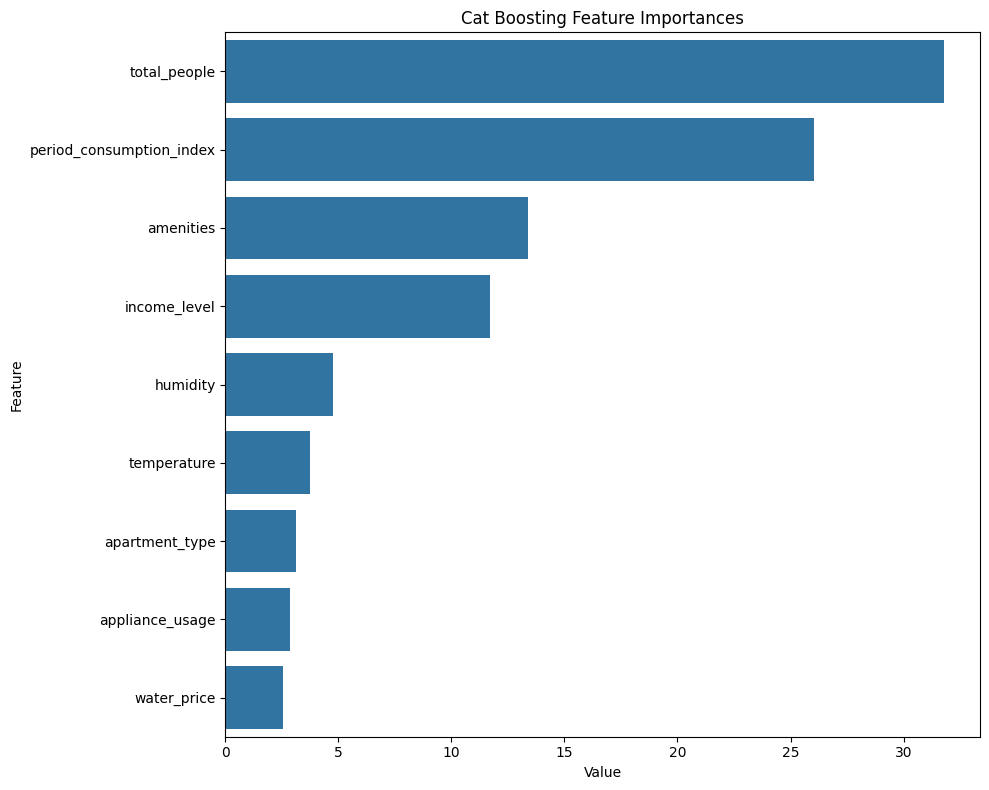

In [32]:
feature_imp = pd.DataFrame(sorted(zip(regressor.feature_importances_, X_t.columns), reverse=True)[:20], columns=['Value','Feature'])
plt.figure(figsize=(10,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Cat Boosting Feature Importances')
plt.tight_layout()
plt.show()

### Hyperparameter tuning using Optuna

In [ ]:
def objective(trial, X, y):
    feature_names = X.columns.tolist()
    total_people_idx = feature_names.index('total_people')
    period_consumption_idx = feature_names.index('period_consumption_index')
    
    # Consolidate parameter suggestions
    params = {
        "iterations": trial.suggest_int("iterations", 100, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 4),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-5, 10.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "border_count": trial.suggest_int("border_count", 100, 255),
        "has_time": True,
        "per_float_feature_quantization": [
            f'{total_people_idx}:border_count=1024', 
            f'{period_consumption_idx}:border_count=1024'
        ],
        "random_state": 42,
        "verbose": 0,
        "task_type": "CPU",
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
    }

    # Conditional parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.01, 10.0)
    if params["bootstrap_type"] in ["Bernoulli", "MVS"]:
        params["subsample"] = trial.suggest_float("subsample", 0.25, 1.0)
    if params["grow_policy"] != "SymmetricTree":
        params["min_data_in_leaf"] = trial.suggest_int("min_data_in_leaf", 1, 200)
    if params["grow_policy"] == "Lossguide":
        params["max_leaves"] = trial.suggest_int("max_leaves", 2, 256)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**params, cat_features=categorical_cols)
        pruning_callback = CatBoostPruningCallback(trial, "RMSE")
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=200,
            callbacks=[pruning_callback],
            use_best_model=True,
            verbose=False
        )
        pruning_callback.check_pruned()
        
        y_pred = model.predict(X_val)
        
        actual = np.expm1(y_val) if y_train.min() >= 0 else y_val
        y_pred = np.expm1(y_pred) if y_train.min() >= 0 else y_pred
        
        fold_score = max(0, 100 - root_mean_squared_error(actual, y_pred))
        scores.append(fold_score)

    return np.mean(scores)

In [ ]:
def tune_catboost_hyperparameters(X, y, n_trials=100):
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.number)
    print("Highest score value: {:.4f}".format(study.best_trial.value))
    print("Best Params:")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")

    return study.best_params

data = data.drop(columns='timestamp')
test_data = test_data.drop(columns='timestamp')

X = data.drop(columns='water_consumption')
y = data["water_consumption"]
# Usage
best_params = tune_catboost_hyperparameters(X, y, n_trials=150)

In [33]:
best_params = {'iterations': 5845,
 'learning_rate': 0.07218403514403844,
 'depth': 2,
 'l2_leaf_reg': 0.0006323189259695252,
 'random_strength': 2.214812489118913e-05,
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.9835016389682567,
 'grow_policy': 'SymmetricTree',
 'border_count': 112,
 'subsample': 0.8787443670199477}

### Final model and prediciton on test set

In [34]:
errcat = []
y_pred_totcat = []

data = data.drop(columns='timestamp')
test_data = test_data.drop(columns='timestamp')
X = data.drop(columns='water_consumption')
y = data["water_consumption"]

feature_names = X.columns.tolist()
total_people_idx = feature_names.index('total_people')
period_consumption_idx = feature_names.index('period_consumption_index')

fold = KFold(n_splits=10, shuffle=False, random_state=None)

for train_ind, test_ind in fold.split(X):
    X_train, X_test = X.loc[train_ind], X.loc[test_ind]
    y_train, y_test = y[train_ind], y[test_ind]
    
    cat= CatBoostRegressor(**best_params, loss_function='RMSE', random_state=121, cat_features=categorical_cols,
                            has_time=True, per_float_feature_quantization=[
                            f'{total_people_idx}:border_count=1024', 
                            f'{period_consumption_idx}:border_count=1024'
                        ])
    cat.fit(X_train, y_train,verbose=False)
    y_pred = cat.predict(X_test)

    print('RMSE', root_mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

    errcat.append(root_mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    p = cat.predict(test_data)
    y_pred_totcat.append(p)
    

RMSE 6.796659401601667
RMSE 9.091900368630355
RMSE 8.652405074868462
RMSE 7.663072888803408
RMSE 7.592424260123405
RMSE 8.399637268398218
RMSE 7.555086565858431
RMSE 5.758663303033501
RMSE 9.03981347965686
RMSE 6.44740581765111


In [35]:
np.mean(errcat)

7.699706842862542

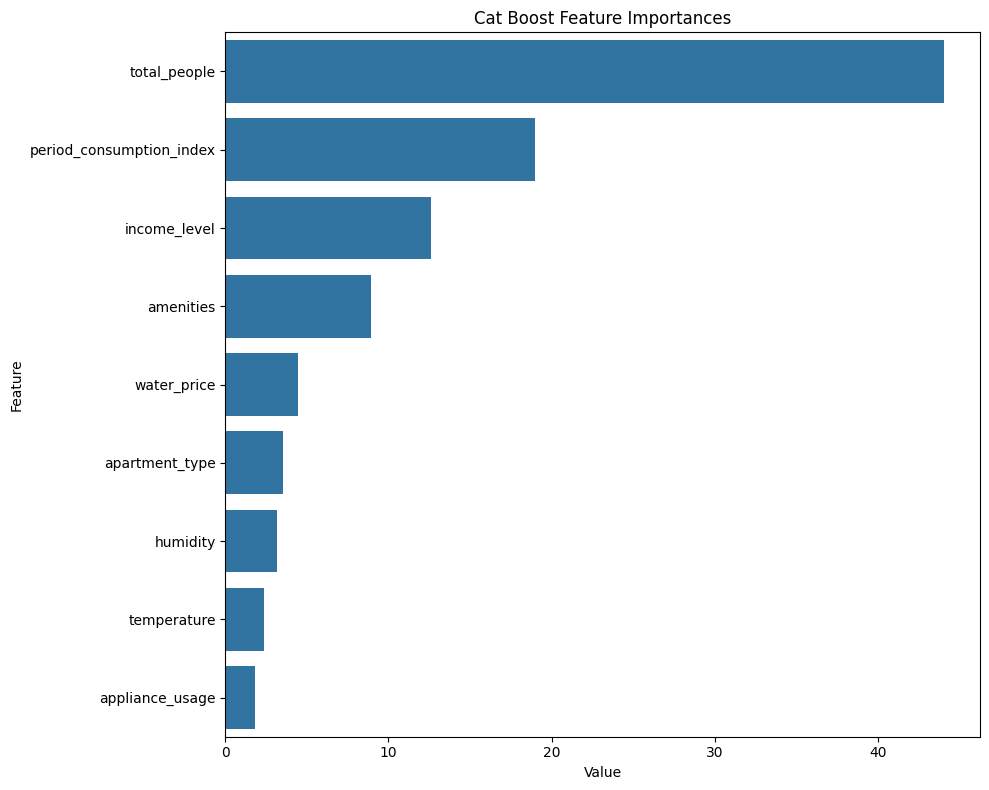

In [36]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:20], columns=['Value','Feature'])
plt.figure(figsize=(10,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Cat Boost Feature Importances')
plt.tight_layout()
plt.show()

In [37]:
values = np.expm1(np.mean(y_pred_totcat,0))
values

array([295.62840214, 190.22410749,  78.63028727, ..., 261.36138997,
       178.82275059,  67.89197922])

In [38]:
final_df = pd.DataFrame({"Timestamp": test_index, "Water_Consumption": values})
final_df

,Timestamp,Water_Consumption
0,11/10/2014 16,295.628402
1,12/10/2014 00,190.224107
2,12/10/2014 08,78.630287
3,12/10/2014 16,121.402814
4,13/10/2014 00,125.592964
...,...,...
5995,01/04/2020 00,235.469350
5996,01/04/2020 08,78.392657
5997,01/04/2020 16,261.361390
5998,02/04/2020 00,178.822751


In [39]:
final_df.to_csv('prediction_final.csv', header=True, index=False)